# PML Project


Update Date: 2022-01-08

Author: Jiajun He, Xiqing MAO

Content: Task2 IWAE



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta    
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
!pip install biopython

In [ ]:
import helper
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
import pandas as pd
from collections import Counter
from scipy.stats import spearmanr

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 16

dataset, weights = helper.get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))
experimental_data = helper.read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)

In [ ]:
class standard_VAE(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500) # 1500 is the number in the papar
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, 2000)
        self.fc23 = nn.Linear(2000, input_size)

        self.device = device
    
    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        z_mu = self.fc131(hidden)
        z_sd = torch.exp(self.fc132(hidden))

        return z_mu, z_sd

    def decoder(self, z):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.ReLU()(self.fc22(hidden))
        x = self.fc23(hidden)

        return x.reshape(z.shape[0], -1, 23)
    
    def forward(self, x, mc_samples_l=1, mc_samples_k=10):
        z_mu, z_sd = self.encoder(x)
        
        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        LOG_Ps = []
        for s in range(mc_samples_l):
            log_p = []
            for sample in range(mc_samples_k):
                z = torch.randn_like(z_mu) * z_sd + z_mu
                x_logit = self.decoder(z)
                log_p.append(
                    torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1, keepdim=True) + \
                    torch.sum(prior.log_prob(z) - posterior.log_prob(z), dim=-1, keepdim=True))
            log_p = torch.cat(log_p, dim=-1)

            # To avoid numerical unstable
            log_p_max = torch.max(log_p, dim=-1, keepdim=True)[0]
            LOG_Ps.append(torch.log(torch.sum(torch.exp(log_p - log_p_max), dim=-1, keepdim=True) / mc_samples_k) + log_p_max)
        LOG_Ps = torch.sum(torch.cat(LOG_Ps, dim=-1), dim=-1) / mc_samples_l
        
        L_IWAE = torch.sum(LOG_Ps)

        return L_IWAE, z_mu, z_sd

## 2.3 IWAE

In [ ]:
def train(model, dl, optimizer, device,sample_size_l, sample_size_k):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model.forward(i[0].to(device),sample_size_l, sample_size_k)
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted_IWAE = standard_VAE(input_size, 30, device=DEVICE).to(DEVICE)

In [ ]:
sample_size_l = 1
sample_size_k = 10
sample_size_l_coor= 50

In [ ]:
EPOCH = 50
ELBOs = []
accs = []
correlations = []
sample_size_l = 1
sample_size_k = 10
sample_size_l_coor= 50

for epoch in tqdm(range(EPOCH)):
    print("EPOCH:", epoch)
    if epoch in range(0, EPOCH, 2):
        acc = helper.check_reconstruct_iwae(dataset, standard_vae_weighted_IWAE)
        accs.append(acc)
        correlation = helper.quantitative_assessment_iwae(dataset, standard_vae_weighted_IWAE, experimental_data, sample_size_l_coor, sample_size_k)
        correlations.append(correlation) 
        print(acc, correlation)
    PATH = "/content/drive/MyDrive/PML-project/IWAE-k-10/" + "IWAE_%d.pkl"%epoch
    torch.save(standard_vae_weighted_IWAE.state_dict(),PATH)

    ELBOs.append(train(standard_vae_weighted_IWAE, dataloader_weighted, Adam(standard_vae_weighted_IWAE.parameters(), lr=1e-4), DEVICE,sample_size_l, sample_size_k))

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/IWAE-k-10/" + "IWAE_6.pkl"
# standard_vae_weighted_IWAE.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
correlation = helper.quantitative_assessment_iwae(dataset, standard_vae_weighted_IWAE, experimental_data, 100, sample_size_k)
print(correlation)

SpearmanrResult(correlation=0.6848255379960598, pvalue=0.0)


In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
standard_vae_weighted_IWAE_dim_2 = standard_VAE(input_size, 2, device=DEVICE).to(DEVICE)

In [ ]:
EPOCH = 50
ELBOs = []
sample_size_l = 1
sample_size_k = 10

for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(standard_vae_weighted_IWAE_dim_2, dataloader_weighted, Adam(standard_vae_weighted_IWAE_dim_2.parameters(), lr=1e-4), DEVICE,sample_size_l, sample_size_k))

100%|██████████| 50/50 [13:50<00:00, 16.61s/it]


In [ ]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = standard_vae_weighted_IWAE_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()

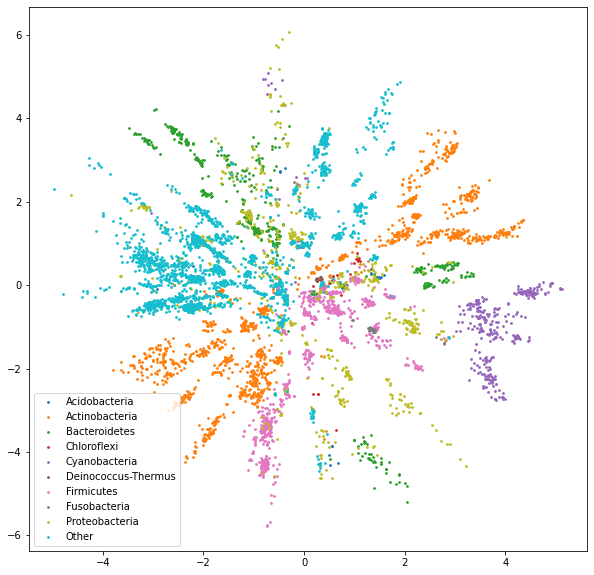

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(helper.phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()